# Mini-project n°2 – Conditional VAEs

Voici la bibliographie que nous avons utilisé : 
- ...

## MNIST data-set and librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchvision.transforms.functional as functional
import torch.nn as nn
from torchvision.datasets import FashionMNIST 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### On télécharge le dataset MNIST

In [2]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = FashionMNIST(root=".",train=True,download=True,transform=transform)
test_dataset = FashionMNIST(root=".",train=False,download=True,transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=False)

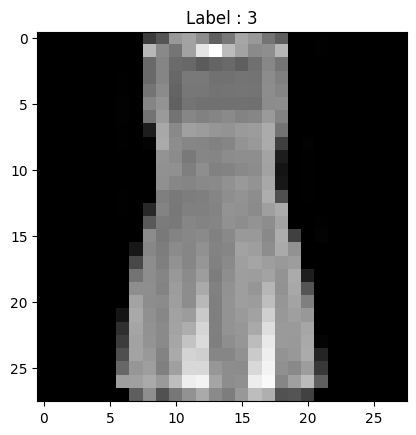

In [3]:
i=np.random.choice(len(train_dataset))
img, label = train_dataset[i]

plt.imshow(img.squeeze(), cmap="gray")
plt.title(f"Label : {label}")
plt.show()

We provide here a global set up, valable for different dataset.

# Conditional Variational Autoencoder (CVAE) Design Choices

## 1. Architecture Choices

### Encoder
- **Convolutional layers:** Capture spatial correlations in image data efficiently (e.g., MNIST format 28x28).  
- **Input channels:** `1 + n_classes` to concatenate the one-hot class labels, enabling the encoder to learn class-specific latent representations.  
- **Feature maps:** 32 → 64 provide sufficient capacity for simple datasets while keeping computation reasonable.  
- **Activation (ReLU):** Adds non-linearity to model complex patterns.  
- **Output:** Flattened features are projected to latent mean `mu` and log-variance `logvar`.

### Decoder
- **Linear layer:** Maps latent vector + conditional label to initial feature maps for upsampling.  
- **Transpose convolutions:** Upsample to reconstruct original image size (7x7 → 14x14 → 28x28).  
- **Activation (Sigmoid):** Ensures output pixel values are between 0 and 1.

## 2. Latent Dimension (`z_dim`)
- Tested different values empirically:  
  - Small (`z_dim=2`): good for visualization but may underfit.  
  - Medium (`z_dim=20-50`): balances compression and reconstruction quality.  
  - Large (`z_dim>100`): better reconstruction but higher risk of overfitting.  

## 3. Hyperparameter Choices
| Hyperparameter | Choice | Reasoning |
|----------------|--------|-----------|
| Batch size     | 128    | Stable gradients while fitting GPU memory. |
| Learning rate  | 1e-3   | Standard starting point for Adam optimizer; allows stable convergence. |
| Number of epochs | 30   | Sufficient for convergence on simple datasets. |
| Optimizer      | Adam   | Efficient for VAE training with adaptive learning rates. |
| KL weight (β)  | 1      | Standard VAE KL-divergence; can be tuned for disentanglement (β-VAE). |

## 4. Loss Function
- **Reconstruction loss (Binary Cross-Entropy):** Measures how well the decoder reconstructs the input image.  
- **KL divergence:** Regularizes the latent distribution to approximate a standard normal distribution, allowing smooth sampling and conditional generation.  
- **β-VAE variant:** Weight `β` can be adjusted to balance reconstruction quality vs latent disentanglement:
```python
loss = recon_loss + beta * kl_loss


## 1. Define the CVAE class

In this section, we define the ConvCVAE class that we will train and use for image generation on Fashion-MNIST. We make the choice of training a **convolutional Conditional VAE**, with the following architecture:

- **The Encoder (Recognition Network):**  
  The encoder takes as input the combination of the input image `x` and the one-hot class label `y` to produce the parameters of the latent distribution.  
  - Convolutional layer 1: channels = 1 + n_classes → 32, kernel_size=4, stride=2, padding=1, followed by ReLU (28×28 → 14×14)  
  - Convolutional layer 2: 32 → 64, kernel_size=4, stride=2, padding=1, followed by ReLU (14×14 → 7×7)  
  - Flattened feature maps are then passed to two parallel fully-connected layers to produce the latent mean vector `μ(x, y)` and log-variance vector `logσ²(x, y)`, both of size `z_dim`  

- **The Latent Space:**  
  - A latent variable `z ~ N(μ, diag(σ²))` is sampled using the **reparameterization trick** to allow gradient flow through the stochastic layer.  
  - This latent `z`, concatenated with the conditional label `y`, is then fed into the decoder to generate the reconstructed output.

- **The Decoder (Generation Network):**  
  The decoder takes the sampled latent variable `z` (plus the conditional label `y`) and outputs a reconstruction of the image in [0,1] for each pixel:  
  - Fully-connected layer: z_dim + n_classes → 64*7*7, followed by reshaping to 64×7×7  
  - Transposed convolution 1: 64 → 32, kernel_size=4, stride=2, padding=1, followed by ReLU (7×7 → 14×14)  
  - Transposed convolution 2: 32 → 1, kernel_size=4, stride=2, padding=1, followed by Sigmoid (14×14 → 28×28)  

- **Conditional Inputs Handling:**  
  The one-hot label `y` is concatenated with both the input image in the encoder and the latent variable in the decoder to condition the generation on the desired class.  

- **Loss Function:**  
  The ConvCVAE is trained using the **sum of two terms**:  
  - **Binary Cross Entropy (BCE)** between the reconstructed output and the original image  
  - **KL divergence** between the approximate posterior `q(z|x,y)` and the prior `p(z)`  

This design allows the model to generate images conditioned on the class label while maintaining a structured latent space that follows a standard Gaussian distribution.



We start with baseline of our architecture.

We move to the core of our model by adding the Encoder and Decoder class link the the CVAE class.

In [6]:
# ----------------------------
# Define CVAE classes with conditional input
# ----------------------------
class ConvEncoder(nn.Module):
    def __init__(self, z_dim, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.conv = nn.Sequential(
            nn.Conv2d(1 + n_classes, 32, kernel_size=4, stride=2, padding=1),  # 28x28 → 14x14
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),              # 14x14 → 7x7
            nn.ReLU(True),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(64 * 7 * 7, z_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, z_dim)

    def forward(self, x, y):
        # y: batch_size x n_classes, one-hot
        y = y.view(y.size(0), self.n_classes, 1, 1).expand(-1, -1, 28, 28)
        x = torch.cat([x, y], dim=1)
        h = self.conv(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class ConvDecoder(nn.Module):
    def __init__(self, z_dim, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.fc = nn.Linear(z_dim + n_classes, 64 * 7 * 7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 → 14x14
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),   # 14x14 → 28x28
            nn.Sigmoid()
        )

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        h = self.fc(z)
        h = h.view(-1, 64, 7, 7)
        x_recon = self.deconv(h)
        return x_recon

class ConvCVAE(nn.Module):
    def __init__(self, z_dim, n_classes):
        super().__init__()
        self.encoder = ConvEncoder(z_dim, n_classes)
        self.decoder = ConvDecoder(z_dim, n_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z, y)
        return recon, mu, logvar


# Reparameterization Trick in the ConvCVAE

In a Variational Autoencoder (VAE) or Conditional VAE, we optimize the Evidence Lower Bound (ELBO):

$$
\mathcal{L}(\theta, \phi; x, y) = \mathbb{E}_{q_\phi(z|x,y)}[\log p_\theta(x|z,y)] - \text{KL}(q_\phi(z|x,y) \,||\, p(z))
$$

where $q_\phi(z|x,y)$ is the approximate posterior produced by the encoder and $p_\theta(x|z,y)$ is the generative model (decoder).



### **1. The Problem**
The latent variable $z \sim q_\phi(z|x,y)$ is stochastic, so naively backpropagating through the sampling step is not possible. To optimize the ELBO w.r.t. both encoder parameters $\phi$ and decoder parameters $\theta$, we need a differentiable path through $z$.



### **2. Change-of-Variables / Reparameterization Trick**
We express $z$ as a differentiable transformation of an auxiliary noise variable $\epsilon \sim \mathcal{N}(0, I)$ that is independent of $x$ and $\phi$:

$$
z = g(\epsilon, \phi, x) = \mu(x,y) + \sigma(x,y) \cdot \epsilon
$$

where $\mu(x,y)$ and $\sigma(x,y)$ are outputs of the encoder.

- In the ConvCVAE code:
```python
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
z = mu + eps * std


# 2. The loss function 

The ConvCVAE is trained by **maximizing the ELBO**, which is equivalent to minimizing:

$$
\mathcal{L}_{\text{CVAE}} = \underbrace{\text{BCE}(x, \hat{x})}_{\text{Reconstruction loss}} + \underbrace{\text{KL}(q_\phi(z|x,y) \,\|\, p(z))}_{\text{Latent regularization}}
$$

- **Binary Cross-Entropy (BCE):** measures how well the decoder reconstructs the input image.
- **KL Divergence:** regularizes the latent distribution to follow a standard normal prior \(p(z) = \mathcal{N}(0,I)\).

We don't add a weight for the moment, we will see the impact of $\beta$ after. 

In [7]:
# -----------------------------------------------------------------------------
# Binary Cross Entropy Loss
# -----------------------------------------------------------------------------
def cvae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss (Binary Cross Entropy)
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    # KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 3. Train de CVAE



##  Training Procedure

1. Sample a mini-batch of images `x` and their labels `y`.  
2. Encode `(x, y)` to obtain `μ(x,y)` and `logσ²(x,y)`.  
3. Sample latent variable `z` using the **reparameterization trick**.  
4. Decode `(z, y)` to reconstruct `x_hat`.  
5. Compute the **loss**: BCE + KL.  
6. Backpropagate and update parameters using an optimizer (e.g., Adam).  
7. Repeat until convergence.


In [8]:
# ----------------------------
# Training
# ----------------------------
z_dim = 20
n_classes = 10
model = ConvCVAE(z_dim, n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, labels in train_loader:
        x = x.to(device)
        y = torch.nn.functional.one_hot(labels, num_classes=n_classes).float().to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(x, y)
        loss = cvae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {train_loss/len(train_dataset):.4f}")


Epoch 1, Loss: 264.7820
Epoch 2, Loss: 245.2353
Epoch 3, Loss: 242.3190
Epoch 4, Loss: 240.6914
Epoch 5, Loss: 239.6013
Epoch 6, Loss: 238.8086
Epoch 7, Loss: 238.1629
Epoch 8, Loss: 237.7361
Epoch 9, Loss: 237.3237
Epoch 10, Loss: 236.9758


# 4. Generation of 5 samples per class

## Inference / Generation

1. Choose a class label `y` (one-hot vector).  
2. Sample `z ~ N(0, I)` from the prior.  
3. Decode `(z, y)` to generate a new image `x_gen`.  

This allows generation of images **conditioned on the desired class** while sampling from the learned latent space.


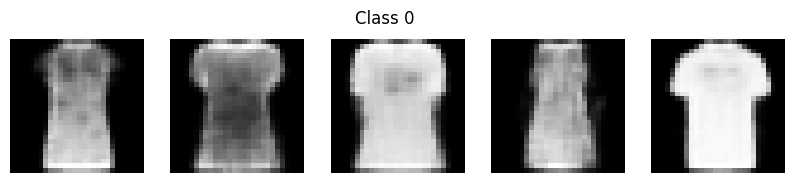

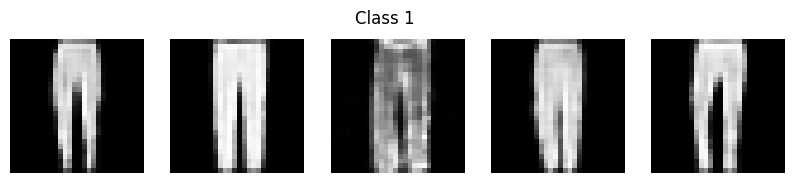

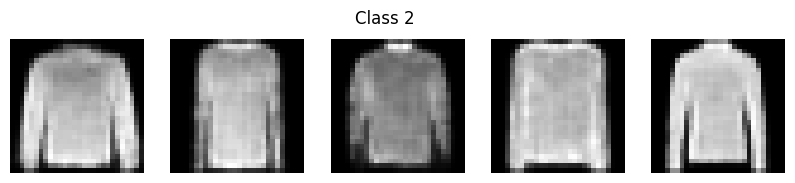

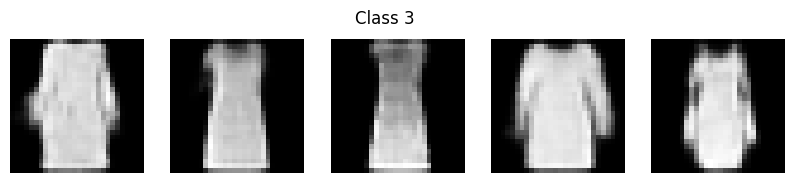

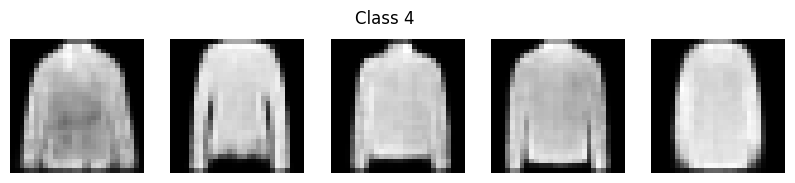

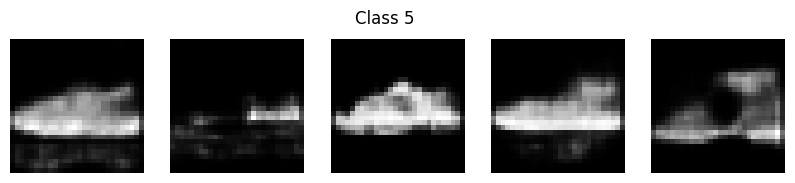

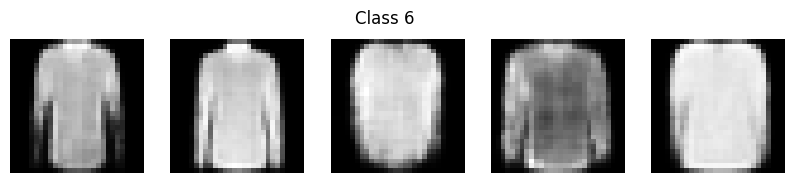

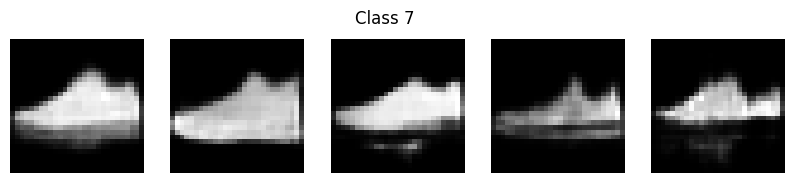

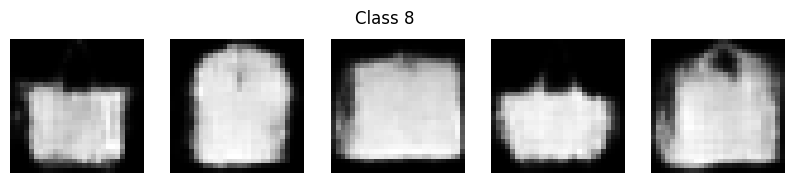

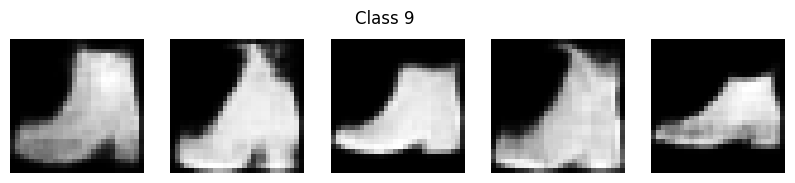

In [9]:
# ----------------------------
# Generate 5 samples per class
# ----------------------------
model.eval()
n_samples = 5
with torch.no_grad():
    for label in range(n_classes):
        y = torch.nn.functional.one_hot(torch.full((n_samples,), label), num_classes=n_classes).float().to(device)
        z = torch.randn(n_samples, z_dim).to(device)
        samples = model.decoder(z, y)
        samples = samples.cpu().numpy()

        # Plot
        fig, axes = plt.subplots(1, n_samples, figsize=(n_samples*2,2))
        for i in range(n_samples):
            axes[i].imshow(samples[i,0], cmap='gray')
            axes[i].axis('off')
        plt.suptitle(f"Class {label}")
        plt.show()

## 6. Interpolation between Images
The objective of this section is to visualize the difference between the space of latent representations and the (original) pixel space. In order to do so, we will perform *image interpolation*, i.e., we will take two random images $x_2$ and $x_2$ from the test set, and interpolate between them: for a given number of interpolation steps $n$, we have:
- In pixel space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by taking, for each pixel, the linear interpolation 
$$\frac{n-t}{n}x_1 + \frac{t}{n}x_2.$$
- In the latent space, the interpolated image $x_t$ at step $t=0,\dots,n$ is given by first computing the linear interpolation $z_t$ between the encodings $z_1$ of $x_1$ and $z_2$ of $x_2$, and then decoding $z_t$.

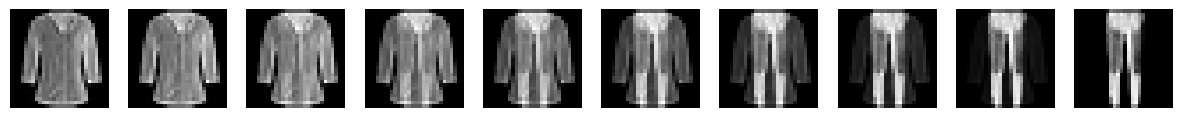

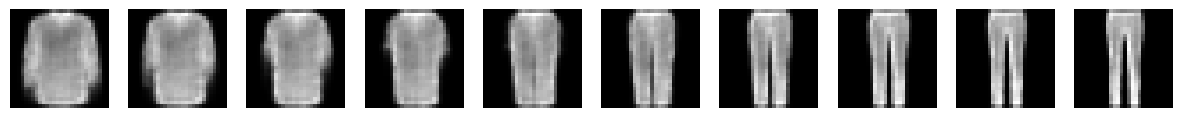

In [10]:
# ----------------------------
# Interpolation in latent space
# ----------------------------
def interpolate_pixel_space(x1, x2, num_steps=10):
    # Ensure the images are on the same device and have the correct shape
    x1 = x1.view(1, 1, 28, 28).to(device)
    x2 = x2.view(1, 1, 28, 28).to(device)

    # Generate interpolation factors between 0 and 1
    t_values = torch.linspace(0, 1, num_steps).to(device).view(-1, 1, 1, 1)

    # Interpolate directly in pixel space
    interpolated_images = x1 * (1 - t_values) + x2 * t_values

    # Move the images to CPU for visualization
    interpolated_images = interpolated_images.cpu().squeeze(1)  # Remove channel dimension if necessary

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i].squeeze(0), cmap='gray')
        ax[i].axis('off')
    plt.show()

def interpolate_latent_space(model, x1, x2, y1, y2, num_steps=10):
    """
    Interpolate between two images in the latent space using the CVAE.
    
    Parameters:
    - model: trained CVAE model
    - x1, x2: input images (1x28x28 tensors)
    - y1, y2: one-hot labels corresponding to x1 and x2
    - num_steps: number of interpolation steps
    """
    model.eval()
    
    # Ensure proper shape and device
    x1 = x1.view(1, 1, 28, 28).to(device)
    x2 = x2.view(1, 1, 28, 28).to(device)
    y1 = y1.view(1, -1).to(device)
    y2 = y2.view(1, -1).to(device)
    
    # Encode images to latent space
    with torch.no_grad():
        mu1, logvar1 = model.encoder(x1, y1)
        z1 = model.reparameterize(mu1, logvar1)
        mu2, logvar2 = model.encoder(x2, y2)
        z2 = model.reparameterize(mu2, logvar2)
    
    # Interpolation factors
    t_values = torch.linspace(0, 1, num_steps).view(-1, 1).to(device)
    
    # Linear interpolation in latent space
    interpolated_images = []
    for t in t_values:
        z_t = (1 - t) * z1 + t * z2
        # Decode the interpolated latent vector
        x_t = model.decoder(z_t, (1 - t) * y1 + t * y2)
        interpolated_images.append(x_t.detach().cpu().squeeze(0).squeeze(0))

    # Plot the interpolated images
    fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
    for i in range(num_steps):
        ax[i].imshow(interpolated_images[i], cmap='gray')
        ax[i].axis('off')
    plt.show()


# ----------------------------
# Example usage
# ----------------------------
x1, label1 = test_dataset[4]
x2, label2 = test_dataset[3]

# Convert labels to one-hot vectors
y1 = torch.nn.functional.one_hot(torch.tensor(label1), num_classes=10).float()
y2 = torch.nn.functional.one_hot(torch.tensor(label2), num_classes=10).float()

# Pixel space interpolation
interpolate_pixel_space(x1, x2)

# Latent space interpolation
interpolate_latent_space(model, x1, x2, y1, y2)



Training CVAE with KL Weight = 1
Epoch 1: Avg Loss=290.5819, BCE=284.7829, KLD=5.7990
Epoch 2: Avg Loss=261.3213, BCE=256.4796, KLD=4.8417
Epoch 3: Avg Loss=257.7108, BCE=252.9784, KLD=4.7324
Epoch 4: Avg Loss=256.1268, BCE=251.4541, KLD=4.6727
Epoch 5: Avg Loss=255.2189, BCE=250.5710, KLD=4.6479
Epoch 6: Avg Loss=254.5512, BCE=249.9164, KLD=4.6348
Epoch 7: Avg Loss=254.0677, BCE=249.4480, KLD=4.6197
Epoch 8: Avg Loss=253.6719, BCE=249.0558, KLD=4.6161
Epoch 9: Avg Loss=253.3963, BCE=248.7783, KLD=4.6180
Epoch 10: Avg Loss=253.1047, BCE=248.4876, KLD=4.6171


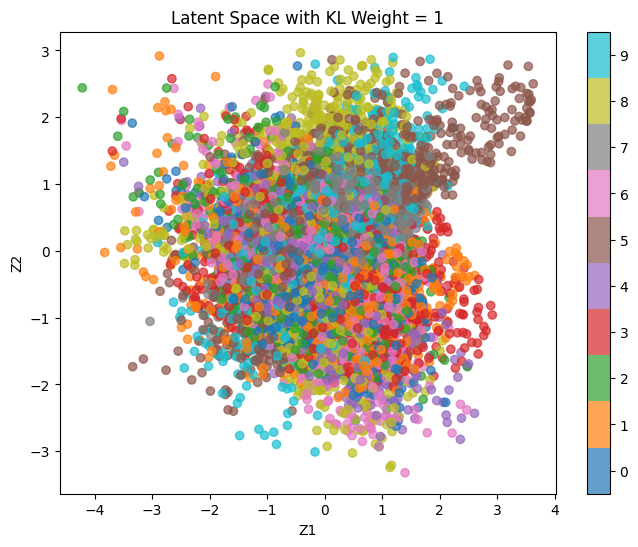


Training CVAE with KL Weight = 10
Epoch 1: Avg Loss=307.5280, BCE=294.4104, KLD=1.3118
Epoch 2: Avg Loss=282.4557, BCE=266.9640, KLD=1.5492
Epoch 3: Avg Loss=280.4002, BCE=264.1351, KLD=1.6265
Epoch 4: Avg Loss=279.5090, BCE=262.8086, KLD=1.6700
Epoch 5: Avg Loss=278.9805, BCE=262.0244, KLD=1.6956
Epoch 6: Avg Loss=278.4585, BCE=261.4178, KLD=1.7041
Epoch 7: Avg Loss=278.2104, BCE=260.9698, KLD=1.7241
Epoch 8: Avg Loss=277.9284, BCE=260.5797, KLD=1.7349
Epoch 9: Avg Loss=277.7381, BCE=260.3342, KLD=1.7404
Epoch 10: Avg Loss=277.7175, BCE=260.1841, KLD=1.7533


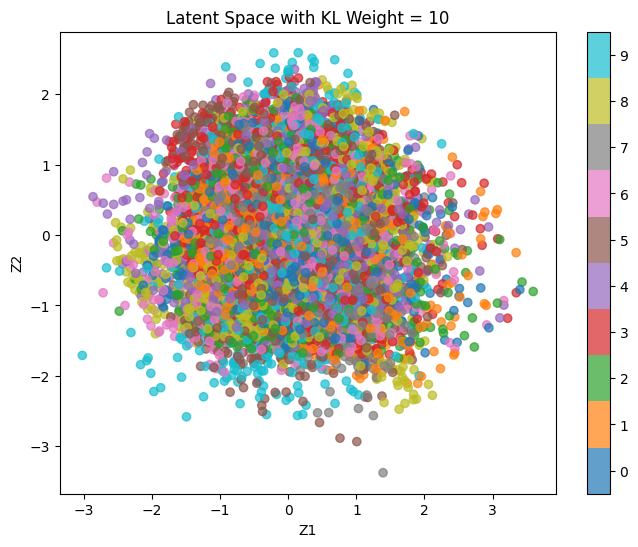


Training CVAE with KL Weight = 100
Epoch 1: Avg Loss=326.6835, BCE=326.6679, KLD=0.0002
Epoch 2: Avg Loss=307.7713, BCE=307.7693, KLD=0.0000
Epoch 3: Avg Loss=307.5649, BCE=307.5642, KLD=0.0000
Epoch 4: Avg Loss=307.5048, BCE=307.5039, KLD=0.0000
Epoch 5: Avg Loss=307.4602, BCE=307.4584, KLD=0.0000
Epoch 6: Avg Loss=307.4199, BCE=307.4194, KLD=0.0000
Epoch 7: Avg Loss=307.3783, BCE=307.3782, KLD=0.0000
Epoch 8: Avg Loss=307.4030, BCE=307.3958, KLD=0.0001
Epoch 9: Avg Loss=307.3445, BCE=307.3372, KLD=0.0001
Epoch 10: Avg Loss=307.3756, BCE=307.3740, KLD=0.0000


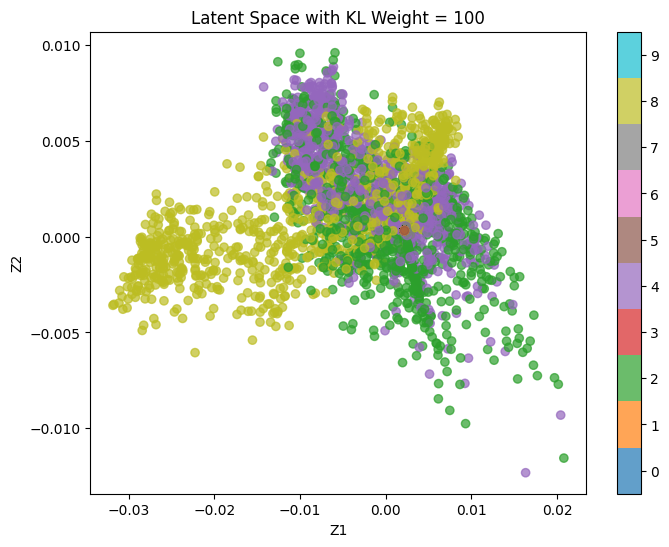

In [ ]:
# ----------------------------
# Loss function with beta parameter
# ----------------------------
def loss_function(recon_x, x, mu, logvar, beta=1):
    """
    Compute CVAE loss with separate BCE and KLD terms.
    beta: weight of the KL divergence term
    """
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

# ----------------------------
# Hyperparameters
# ----------------------------
latent_dims = 2  # For visualization
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
kl_weights = [1, 10, 100]

# ----------------------------
# Training and plotting function
# ----------------------------
def train_and_plot(kl_weight):
    model = ConvCVAE(latent_dims, n_classes=10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            y = nn.functional.one_hot(labels, num_classes=10).float().to(device)
            
            optimizer.zero_grad()
            recon, mu, logvar = model(data, y)
            loss, bce, kld = loss_function(recon, data, mu, logvar, beta=kl_weight)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
        
        avg_loss = epoch_loss / len(train_loader.dataset)
        avg_bce = bce_loss / len(train_loader.dataset)
        avg_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Avg Loss={avg_loss:.4f}, BCE={avg_bce:.4f}, KLD={avg_kld:.4f}')
    
    # Plot latent space after training
    plot_latent_space(model, kl_weight)

# ----------------------------
# Function to plot latent space
# ----------------------------
def plot_latent_space(model, kl_weight):
    model.eval()
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        y = nn.functional.one_hot(labels, num_classes=10).float().to(device)
        
        mu, logvar = model.encoder(data, y)  # Encode conditioned on labels
        z = mu.cpu().numpy()  # Use mean for visualization
        labels = labels.numpy()
        
        plt.figure(figsize=(8,6))
        scatter = plt.scatter(z[:,0], z[:,1], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# ----------------------------
# Run training and visualization for different KL weights
# ----------------------------
for kl_weight in kl_weights:
    print(f'\nTraining CVAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)
